<a href="https://colab.research.google.com/github/Dicere/WB_Internship/blob/main/0_6_Generate_feature_f1_f8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install catboost
!pip install lazypredict
!pip install featuretools

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 8.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 618.0/618.0 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 22.3 MB/s eta 0:00:00


In [2]:
from google.colab import output
output.enable_custom_widget_manager()

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.notebook import tqdm
from catboost import CatBoostClassifier
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, classification_report, recall_score, precision_recall_curve,precision_score, precision_recall_fscore_support
import statsmodels.api as sm
from sklearn.model_selection import StratifiedKFold
from lazypredict.Supervised import LazyClassifier
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv('/content/drive/MyDrive/WB_стажировка/wb_school_task_2.csv.gzip',compression='gzip')
df = df.drop_duplicates(ignore_index=True)

In [5]:
aggs_list = ['min','max', 'mean', 'median', 'count', 'sum']

In [6]:
df_agg = df[['id3','f1','f2','f3','f4','f5','f6','f7','f8']].groupby(by=['id3']).agg(aggs_list).reset_index()
df_agg.columns = ['_by_id3_'.join(col) for col in df_agg.columns.values]
df_agg = df_agg.rename(columns={'id3_by_id3_':'id3'})

In [7]:
df1 = pd.merge(df,df_agg,how='left',on=['id3'])

In [ ]:
df1[df1.filter(regex='f1').columns]

,f1,f1_by_id3_min,f1_by_id3_max,f1_by_id3_mean,f1_by_id3_median,f1_by_id3_count,f1_by_id3_sum
0,1,1,15,5.67,1.00,3,17
1,10,10,10,10.00,10.00,1,10
2,4,2,38,9.00,4.00,9,81
3,6,1,339,33.15,10.50,26,862
4,19,19,19,19.00,19.00,1,19
...,...,...,...,...,...,...,...
3117,2,1,96,12.74,7.00,35,446
3118,8,1,15,5.80,3.00,5,29
3119,13,1,89,15.36,6.50,14,215
3120,3,1,66,18.00,12.50,14,252


In [ ]:
df1[df1.filter(regex='_sum').columns]

,f2,f2_min,f2_max,f2_mean,f2_median,f2_count,f2_sum,sum_f1_f2,sum_f2_f3,sum_f2_f4,...,division_f2_f4,division_f4_f2,division_f2_f5,division_f5_f2,division_f2_f6,division_f6_f2,division_f2_f7,division_f7_f2,division_f2_f8,division_f8_f2
0,1,1,14,5.33,1.00,3,16,2,2.00,12,...,0.09,11.00,0.08,13.00,0.23,4.27,0.06,18.00,0.03,36.00
1,6,6,6,6.00,6.00,1,6,16,8.70,52,...,0.13,7.67,1.50,0.67,1.35,0.74,0.07,15.00,0.06,18.17
2,4,2,35,8.33,4.00,9,75,8,8.00,18,...,0.29,3.50,inf,0.00,0.89,1.12,1.00,1.00,0.67,1.50
3,6,1,132,23.00,10.00,26,598,12,11.00,380,...,0.02,62.33,0.20,5.00,1.26,0.80,0.43,2.33,0.40,2.50
4,18,18,18,18.00,18.00,1,18,37,23.00,24,...,3.00,0.33,4.50,0.22,3.60,0.28,0.69,1.44,0.55,1.83
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3117,2,1,93,11.46,4.00,35,401,4,5.00,21,...,0.11,9.50,2.00,0.50,0.47,2.13,0.22,4.50,0.22,4.50
3118,8,1,8,3.20,2.00,5,16,16,12.38,139,...,0.06,16.38,0.10,10.38,1.91,0.52,0.44,2.25,0.44,2.25
3119,12,1,84,14.36,5.50,14,201,25,17.00,157,...,0.08,12.08,6.00,0.17,2.43,0.41,1.00,1.00,0.86,1.17
3120,3,1,60,17.00,12.50,14,238,6,8.00,208,...,0.01,68.33,0.16,6.33,0.65,1.55,0.03,34.33,0.02,51.67


In [ ]:
# df = df.rename(columns={"f1": "number_reviews_by_user", "f3": "mean_rating_user","f4": "number_reviews_by_item","f5":"number_photos","f6": "mean_rating_item","f7": "number_purchased","f8": "number_orders"})

In [ ]:
clear_df = df[['f1','f2','f3','f4','f5','f6','f7','f8']]

In [ ]:
feature_dict = {}
conversions_list = ['sum','subtraction','division','multiplication']

In [ ]:
# for i in conversions_list:
idx=0
for b in range(len(clear_df.columns)-1):
  for i in range(b+1,len(clear_df.columns)):
    name = str('sum_'+clear_df.columns[b] +"_"+ clear_df.columns[i])
    feature_dict[name] = clear_df.iloc[:,b] + clear_df.iloc[:,i]

In [ ]:
for b in range(len(clear_df.columns)-1):
  for i in range(b+1,len(clear_df.columns)):
    name = str('subtraction_'+clear_df.columns[b] +"_"+ clear_df.columns[i])
    feature_dict[name] = abs(clear_df.iloc[:,b] - clear_df.iloc[:,i])

In [ ]:
for b in range(len(clear_df.columns)-1):
  for i in range(b,len(clear_df.columns)):
    name = str('multiplication_'+clear_df.columns[b] +"_"+ clear_df.columns[i])
    feature_dict[name] = abs(clear_df.iloc[:,b] * clear_df.iloc[:,i])

In [ ]:
for b in range(len(clear_df.columns)-1):
  for i in range(b,len(clear_df.columns)):
    if clear_df.iloc[:,b] <=0 or clear_df.iloc[:,i]<=0:
          name = str('division_'+clear_df.columns[b] +"_"+ clear_df.columns[i])
          feature_dict[name] = 0
          name = str('division_'+clear_df.columns[i]+"_"+clear_df.columns[b])
          feature_dict[name] = 0
    else:
      name = str('division_'+clear_df.columns[b] +"_"+ clear_df.columns[i])
      feature_dict[name] = abs((clear_df.iloc[:,b] / clear_df.iloc[:,i]).fillna(0))
      name = str('division_'+clear_df.columns[i]+"_"+clear_df.columns[b])
      feature_dict[name] = abs((clear_df.iloc[:,i] /clear_df.iloc[:,b]).fillna(0))

ValueError: ignored

In [ ]:
df1 = df1.assign(**feature_dict)

In [ ]:
cols_to_drop = df1.columns[df1.nunique() == 1]
df1 = df1.drop(cols_to_drop, axis=1)

In [ ]:
df1

,id1,id2,id3,text,f1,f2,f3,f4,f5,f6,...,division_f7_f5,division_f5_f8,division_f8_f5,division_f6_f7,division_f7_f6,division_f6_f8,division_f8_f6,division_f7_f7,division_f7_f8,division_f8_f7
0,7596126584852021591,173777575861152844,18254136755182295358,"Хотела купить на замену старых,по итогу эти у...",1,1,1.00,11,13,4.27,...,1.38,0.36,2.77,0.24,4.21,0.12,8.43,1.00,0.50,2.00
1,5327406586753254371,14366783259208998381,2324030737335224220,Запах по сравнению с обычным DOVE никакой. Оно...,10,6,2.70,46,4,4.43,...,22.50,0.04,27.25,0.05,20.29,0.04,24.58,1.00,0.83,1.21
2,2636757786779776109,16985421652518589249,4904562693381133981,"Кабель подошёл, хорошо работает.",4,4,4.00,14,0,4.50,...,inf,0.00,inf,1.12,0.89,0.75,1.33,1.00,0.67,1.50
3,15432976385014516263,2629180387521298831,13541353053200353836,"Восторг! Очень приятный аромат, держится долго...",6,6,5.00,374,30,4.77,...,0.47,2.00,0.50,0.34,2.93,0.32,3.14,1.00,0.93,1.07
4,11933982800034911890,14531191561111600318,9121890650636487522,Визуально все хорошо. Не пробовали. Купили в п...,19,18,5.00,6,4,5.00,...,6.50,0.12,8.25,0.19,5.20,0.15,6.60,1.00,0.79,1.27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3117,764513678578182418,15635360211325277203,6836784353719029392,"Стекло не плохое,но есть один минус на техно с...",2,2,3.00,19,1,4.26,...,9.00,0.11,9.00,0.47,2.11,0.47,2.11,1.00,1.00,1.00
3118,6838893897482150395,13016265854619171030,12090430373311552618,"Всё пришло запаковано, ничего не сломано. Лучш...",8,8,4.38,131,83,4.18,...,0.22,4.61,0.22,0.23,4.30,0.23,4.30,1.00,1.00,1.00
3119,3080528623596565085,17787644417937804433,18003133089489520237,"Мне нравятся 👍🏻 я очень аллергичная, посоветов...",13,12,5.00,145,2,4.94,...,6.00,0.14,7.00,0.41,2.43,0.35,2.83,1.00,0.86,1.17
3120,13059704988549832630,997055248102065549,12214993272083833542,"Спасибо, целая пришла. Хорошо упаковано",3,3,5.00,205,19,4.65,...,5.42,0.12,8.16,0.05,22.16,0.03,33.34,1.00,0.66,1.50


In [ ]:
X = df1[df1.drop('label', axis=1).columns[4::]]
y=df1.label

In [ ]:
features_for_selection = list(X.columns[8::])
current_feat = list(X.columns[:8])

In [ ]:
len(features_for_selection)

197

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)
X_val, X_test, y_val, y_test =  train_test_split(X_test, y_test, test_size=0.2, random_state=42,stratify=y_test)

In [ ]:
from catboost import CatBoostRegressor, Pool, EShapCalcType, EFeaturesSelectionAlgorithm
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
clf = CatBoostClassifier(random_state=42)


train_pool = Pool(X_train[current_feat], y_train, feature_names=current_feat)
test_pool = Pool(X_test[current_feat], y_test, feature_names=current_feat)
clf.fit(train_pool,verbose=0)

y_pred = clf.predict_proba(X_test)[:, 1]
y_pred_metki =  clf.predict( X_test)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred_metki, average='macro')
roc = roc_auc_score(y_test, y_pred)
print("AUC_ROC----"+str(roc))
print("F1-score-----"+str(f1))
print("Precision-----"+str(precision))
print("Recall-----"+str(recall))

AUC_ROC----0.7779973649538867
F1-score-----0.6208291203235592
Precision-----0.791304347826087
Recall-----0.61034255599473


In [ ]:
n_feature = 20
iter=0

In [ ]:
scores = []
best_f1 = 0
columns_on_with_best_score=[]
scores = []
count=1
for i in range(n_feature):
  print('_'*5+f'Iter_{i}'+'_'*5)
  # features_for_selection = list(X.columns[8::])
  current_feat = list(X.columns[:8])
  clf = CatBoostClassifier(random_state=42)
  train_pool = Pool(X_train, y_train, feature_names=list(X.columns))
  test_pool = Pool(X_val, y_val, feature_names=list(X.columns))
  summary = clf.select_features(
      train_pool,
      eval_set=test_pool,
      features_for_select=features_for_selection,
      num_features_to_select=count,
      steps=20,
      algorithm=EFeaturesSelectionAlgorithm.RecursiveByShapValues,
      shap_calc_type=EShapCalcType.Regular,
      train_final_model=False,
      logging_level='Silent',
      plot=False
  )
  for b in list(summary['selected_features_names']):
    # features_for_selection.remove(b)
    current_feat.append(b)

  count+=1

  train_pool = Pool(X_train[current_feat], y_train, feature_names=current_feat)
  test_pool = Pool(X_test[current_feat], y_test, feature_names=current_feat)
  clf.fit(train_pool,verbose=0)

  y_pred = clf.predict_proba(X_test)[:, 1]
  y_pred_metki =  clf.predict(X_test)
  precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred_metki, average='macro')
  roc = roc_auc_score(y_test, y_pred)
  scores.append(f1)
  print(len(current_feat),current_feat)
  print("AUC_ROC----"+str(roc))
  print("F1-score-----"+str(f1))
  print("Precision-----"+str(precision))
  print("Recall-----"+str(recall))
  if f1>best_f1:
    best_f1 = f1
    columns_on_with_best_score = current_feat
    iter = i
  # print("F1-score-----"+str(f1))


_____Iter_0_____
9 ['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'division_f1_f2']
AUC_ROC----0.757905138339921
F1-score-----0.6612466124661247
Precision-----0.8148967551622419
Recall-----0.6406455862977603
_____Iter_1_____
10 ['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'division_f1_f2', 'division_f4_f7']
AUC_ROC----0.7789855072463769
F1-score-----0.6612466124661247
Precision-----0.8148967551622419
Recall-----0.6406455862977603
_____Iter_2_____
11 ['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'multiplication_f3_f6', 'division_f1_f2', 'division_f4_f7']
AUC_ROC----0.7882081686429513
F1-score-----0.6612466124661247
Precision-----0.8148967551622419
Recall-----0.6406455862977603
_____Iter_3_____
12 ['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f2_median', 'sum_f3_f6', 'division_f1_f2', 'division_f4_f7']
AUC_ROC----0.796772068511199
F1-score-----0.6341463414634146
Precision-----0.7688053097345133
Recall-----0.6200592885375493
_____Iter_4_____
13 ['f1', 'f2', 'f3', 'f4', 'f5', 

In [ ]:
n_feature

20

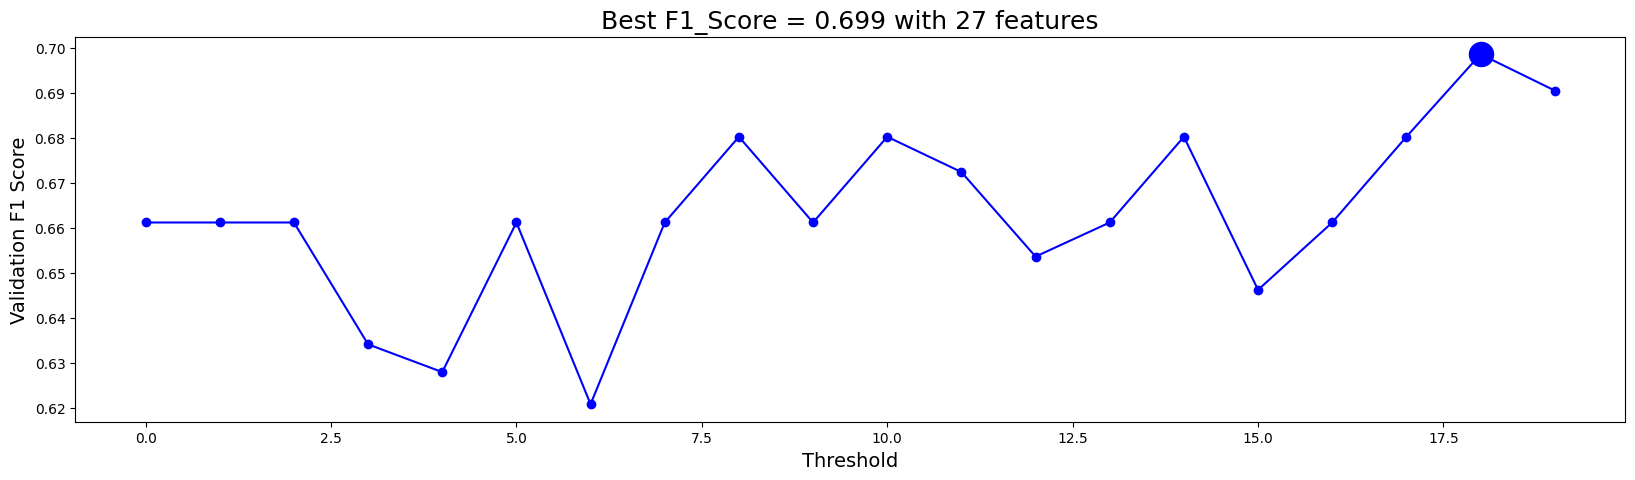

In [ ]:
# PLOT THRESHOLD VS. F1_SCORE
plt.figure(figsize=(20,5))
plt.plot(scores,'-o',color='blue')
plt.scatter([iter],[best_f1], color='blue', s=300, alpha=1)
plt.xlabel('Threshold',size=14)
plt.ylabel('Validation F1 Score',size=14)
plt.title(f'Best F1_Score = {best_f1:.3f} with {len(columns_on_with_best_score)} features',size=18)
plt.show()

AUC_ROC----0.7779973649538867
F1-score-----0.6208291203235592
Precision-----0.791304347826087
Recall-----0.61034255599473


In [ ]:
type(summary['selected_features_names'][0])

str

In [ ]:
features_for_selection - list(summary['selected_features_names'][0])

TypeError: ignored

In [ ]:
current_feat.append(summary['selected_features_names'][0])

In [ ]:
X_train[current_feat]

,f1,f2,f3,f4,f5,f6,f7,f8
398,3,3,5.00,14,3,5.00,7,12
1243,3,3,4.67,9,7,4.00,3,6
367,1,1,5.00,10192,5663,4.55,7,17
117,3,3,5.00,2,1,5.00,22,23
1001,2,2,5.00,14,0,4.21,1,6
...,...,...,...,...,...,...,...,...
1569,1,1,1.00,279,63,4.14,8,10
2304,3,3,3.67,84,51,4.79,25,35
505,25,24,4.72,2050,587,4.49,31,37
2783,1,1,1.00,13,4,1.23,6,9


In [ ]:
summary['selected_features_names'][0]

'division_f2_f1'

In [ ]:
X[summary['selected_features_names'][0]]

0      1.00
1      0.60
2      1.00
3      1.00
4      0.95
       ... 
3117   1.00
3118   1.00
3119   0.92
3120   1.00
3121   0.69
Name: division_f2_f1, Length: 3122, dtype: float64

In [ ]:
summary['selected_features_names'][0]

'division_f2_f1'